# Generate RAG responses

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import joblib
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

import evaluate
import bert_score

from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.vectorstores import FAISS
from langchain_core.runnables import RunnableLambda
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate



In [2]:
# Load OpenAI API from .env file
load_dotenv(dotenv_path='./api.env') # Change this to your .env file
print(f"API key loaded: {os.getenv('OPENAI_API_KEY')[:10]}...")

API key loaded: sk-proj-Hw...


## Functions for generation

In [3]:
def run_zeroshot_prediction(model_name='gpt-3.5-turbo', questions=[], temperature=0, top_p=1.0):

    # Build a chain for zero-shot prediction with GPT-3.5-turbo
    model = ChatOpenAI(model=model_name, temperature=0, top_p=top_p)

    system_prompt = """
    You are a helpful assistant that provides concise answers questions patients have about ADHD medication
    """

    user_prompt = """
    Answer the question provided below.
    Your answer should be a few sentences and be concise.

    Here is an example of how you should answer:

    Question: What changes typically occur in a child’s mood or energy after starting Intuniv?
    Answer: After starting Intuniv, children often experience increased calmness, reduced impulsivity, and better sleep. However, some also show decreased energy, fatigue, irritability, or emotional flatness. Responses vary depending on the dosage and individual sensitivity.

    Use this style in your own answers.

    Question: {question}
    """

    #  Prompt template
    prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_prompt),
        HumanMessagePromptTemplate.from_template(user_prompt)
    ])

    # Chain
    chain = (
        {"question": lambda x: x}  # passthrough identity for each input question
        | prompt
        | model
        | (lambda m: m.content)  # extract .content from AIMessage list
    )
    # Run the GPT-3.5-turbo pipeline over the questions
    responses = chain.batch(questions)

    # Text from responses
    gentext = [item.split('Answer: ')[-1] for item in responses]
    
    return gentext


In [4]:
# Functions to run RAG with specified embeddings and vector stores

def build_RAG_chain(model_name='gpt-3.5-turbo', temperature=0, top_p=1):
    """Return a LangChain pipeline for RAG generation"""

    system_prompt = """
    You are a helpful assistant that provides concise, evidence-based answers to user questions based on patient-provided documents.
    Your goal is to summarize real experiences with medical treatments as described in the text.

    """

    user_prompt = """
    Based on the patient review document attached, answer the following question using only information found directly in the document. 
    Your answer should be a few sentences and be concise.
    Avoid speculation, generalizations, or added interpretation. Focus only on what patients actually report.

    Here is an example of how you should answer:

    Question: What changes typically occur in a child’s mood or energy after starting Intuniv?
    Answer: After starting Intuniv, children often experience increased calmness, reduced impulsivity, and better sleep. However, some also show decreased energy, fatigue, irritability, or emotional flatness. Responses vary depending on the dosage and individual sensitivity.

    Use this style in your own answers.

    Question: {question}

    --- BEGIN DOCUMENT ---
    {document_text}
    --- END DOCUMENT ---
    """

    # Build prompt
    prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_prompt),
        HumanMessagePromptTemplate.from_template(user_prompt)
    ])
    
    # Model and chain
    model = ChatOpenAI(model=model_name, temperature=temperature, top_p=top_p)
    chain = (
        #lambda x: {'question': x["question"], 'document_text': x['document_text']}
        RunnableLambda(lambda x: {'question': x["question"], 'document_text': x['document_text']})
        | prompt
        | model
        | (lambda m: m.content)  # extract .content from AIMessage list
    )
    return chain




def run_rag_chain(model_name, temperature, top_p, vectorstore, questions, rag_k=4):
    """Run a RAG chain over a list of questions using the specified model and vectorstore, returning the generated responses."""

    chain = build_RAG_chain(model_name=model_name, temperature=temperature, 
                            top_p=top_p)
    responses = []
    for question in questions:
        document_text = vectorstore.similarity_search(query=question, k=rag_k)
        document_text = "\n".join([item.page_content for item in document_text])
        response = chain.invoke({'question': question, 'document_text': document_text})
        responses.append(response)

    return responses




def evaluate_rag_model(model_name, vectorstore_path, embedding, questions, references, rag_k=5, 
                       temperature=0, top_p=1):
    """Runs the RAG pipeline with a specified model and embedding to generate answers and 
    compute performance metrics."""

    vectorstore = FAISS.load_local(
        vectorstore_path, 
        embeddings=embedding, 
        allow_dangerous_deserialization=True
        )
    responses = run_rag_chain(
        model_name=model_name, 
        vectorstore=vectorstore, 
        questions=questions, 
        temperature=temperature, 
        top_p=top_p,
        rag_k=rag_k)
    answers = [r.split('\nAnswer: ')[-1] for r in responses]
    results = compute_performance(references=references, candidates=answers)
    
    return answers, results


def compute_performance(references, candidates):
    """Return a dictionary of Rouge and BERTScore metrics evaluating quality of a list 
    of generated candidates relative to a corresponding list of references"""
    
    rouge = evaluate.load('rouge')
    results = rouge.compute(predictions=candidates, references=references)
    bscores = bert_score.score(cands=candidates, refs=references, lang='en', 
                               model_type='bert-base-uncased', rescale_with_baseline=True)
    bscores = np.asarray([item.numpy() for item in bscores]).mean(axis=-1) # Average over all samples
    results.update(dict(zip(['bertscore_precision', 'bertscore_recall', 'bertscore_f1'], bscores)))
    
    return results
    

## Run zero-shot

In [5]:
# Dictionary to store results
STORE = {}

In [6]:
# Fetch data
testdata = pd.read_csv('data/test_data.csv', index_col=None)
questions = testdata['QUESTIONS'].tolist()
answers = testdata['ANSWERS'].tolist()

In [21]:
# Zero-shot with GPT-3.5
responses = run_zeroshot_prediction(model_name='gpt-3.5-turbo', temperature=0.25, top_p=1, 
                                    questions=questions)

# Save generated text
with open("data/responses/test-data/gpt-3.5-test-zeroshot.txt", 'w') as f:
    for item in responses:
        f.write(item + '\n\n')

# Compute performance
results = compute_performance(references=answers, candidates=responses)
STORE['gpt-3.5-zeroshot'] = results

In [22]:
# Zero-shot with GPT-4o
responses = run_zeroshot_prediction(model_name='gpt-4o', temperature=0.25, top_p=1, 
                                    questions=questions)

# Save generated text
with open("data/responses/test-data/gpt-4o-test-zeroshot.txt", 'w') as f:
    for item in responses:
        f.write(item + '\n\n')

# Compute performance
results = compute_performance(references=answers, candidates=responses)
STORE['gpt-4o-zeroshot'] = results

In [23]:
# View zero-shot performance
df = pd.DataFrame(STORE).transpose()
df

,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1
gpt-3.5-RAG,0.358602,0.103362,0.226566,0.226559,0.520008,0.485802,0.502868
gpt-3.5-zeroshot,0.325382,0.116079,0.223603,0.223681,0.493146,0.416614,0.453661
gpt-4o-zeroshot,0.361135,0.121577,0.242720,0.243154,0.496800,0.478077,0.487848


## Run RAG on full test data with optimal hyperparameters

In [41]:
# Run RAG on full test data with optimal hyperparameters

# Hyperparameters
embedding_name = 'text-embedding-3-large'
embedding = OpenAIEmbeddings(model=embedding_name, show_progress_bar=False)            
k = 15
temperature = 0.25
top_p = 1.0

# Run rag
responses, results = evaluate_rag_model(
    model_name='gpt-3.5-turbo', # Generative model
    vectorstore_path=f'data/vector-stores/{embedding_name}-dotP',
    embedding=embedding,
    questions=questions,
    references=answers,
    rag_k=k, 
    temperature=temperature, 
    top_p=top_p
    )
responses = [item.split('Answer: ')[-1] for item in responses]

# Save responses
with open(f"data/responses/test-data/gpt-3.5-RAG.txt", 'w') as f:
    for item in responses:
        f.write(item + '\n\n')    

# Store results
STORE["gpt-3.5-RAG"] = results


In [42]:
# View performance
joblib.dump(STORE, 'data/test-results-store.pkl')
df = pd.DataFrame(STORE).transpose()
df

,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1
gpt-3.5-RAG,0.363274,0.105933,0.228388,0.228705,0.521517,0.490406,0.506286
gpt-3.5-zeroshot,0.325382,0.116079,0.223603,0.223681,0.493146,0.416614,0.453661
gpt-4o-zeroshot,0.361135,0.121577,0.242720,0.243154,0.496800,0.478077,0.487848


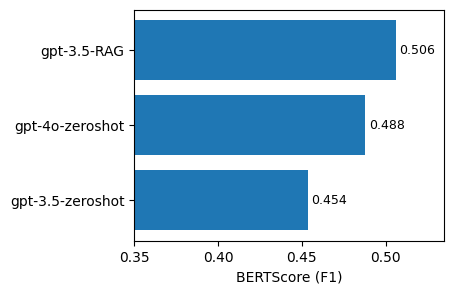

In [44]:
# Plot results as bar graph
dfsel = df.loc[:,'bertscore_f1'].sort_values()
y = dfsel.values
plt.figure(figsize=(4,3))
plt.barh(range(len(y)), y)
plt.yticks(range(len(y)), dfsel.index);
plt.xlabel('BERTScore (F1)');
for i, val in enumerate(y):
    plt.text(val + 0.002, i, f'{val:.3f}', va='center', fontsize=9)
plt.xlim((0.35,0.535));

## Compare an example response

In [45]:
# Question
questions[-2]

'How do ADHD medications affect gut health?'

In [46]:
# GPT 3.5 zero-shot
file = 'data/responses/test-data/gpt-3.5-test-zeroshot.txt'
with open(file, 'r') as f:
    text = f.read().strip().split('\n\n')
text[-2]


"ADHD medications can sometimes cause gastrointestinal side effects such as stomach upset, nausea, or decreased appetite. However, there is limited evidence to suggest a direct impact on gut health. It's important to discuss any concerns with your healthcare provider."

In [47]:
# GPT-4o zero-shot
file = 'data/responses/test-data/gpt-4o-test-zeroshot.txt'
with open(file, 'r') as f:
    text = f.read().strip().split('\n\n')
text[-2]

"ADHD medications, particularly stimulants like methylphenidate and amphetamines, can affect gut health by causing side effects such as reduced appetite, stomach pain, nausea, or constipation. These effects are generally mild and temporary, but they can vary based on the individual and the specific medication. Non-stimulant medications may have different gastrointestinal side effects, and it's important to monitor any changes and discuss them with a healthcare provider."

In [48]:
# GPT-3.5 with RAG
file = 'data/responses/test-data/gpt-3.5-RAG.txt'
with open(file, 'r') as f:
    text = f.read().strip().split('\n\n')
text[-2]


'Some ADHD medications, such as Methylphenidate and Dexmethylphenidate, have been reported to cause side effects like diarrhea. Additionally, Strattera has been mentioned to cause constipation in some individuals. These gastrointestinal effects may vary among patients using these medications.'

In [49]:
# Ground truth (GPT-4o with all documents in context)
print(answers[-2])

Patients report several gastrointestinal side effects from ADHD medications. Some individuals experienced nausea, diarrhea, constipation, and appetite loss. A few also mentioned weight loss associated with reduced food intake. One patient reported digestive discomfort linked to specific pill binders. Another noted that methylphenidate helped regulate their digestive tract. These effects vary by medication and individual.
